# **Question 1** - Adaptive Runge-Kutte Integrator

The Runge-Kutte method is as follows:
1. Step to the halfway point and evaluate the derivative there:
$$ f_0 = f(x, y)$$
$$y_1 = y(x) + \frac{h}{2}f_0$$
$$f_1 = f(x + \frac{h}{2}, y_1)$$

2. Repeat step 1, but use $f_1$ to step to the halfway point and re-evaluate the derivative:
$$y_2 = y(x) + \frac{h}{2}f_1$$
$$f_2 = f(x + \frac{h}{2}, y_2)$$

3. Now use $f_2$ to step across the entire interval and evaluate the derivative there:
$$y_3 = y(x) + hf_2$$
$$f_3 = f(x + h, y_3)$$

4. Finally, the value of $y$ at $x + h$ is given by:
$$y(x + h) = y(x) + \frac{h}{6}(f_0 + 2f_1 + 2f_2 + f_3)$$


For an eccentric orbit, it doesn't always make sense to have a constant step size $h$, as the planet does not spend equal amounts of time at each point of the orbit. In this case, it is more time-efficient to make an adaptive step size. To do this:

1. Take an RK4 step with the current step size $h$ and compare with the result you get if you take two steps with step size $h/2$. The difference between these two is a measure of the error.

2. If the error is smaller than the desired tolerance, keep the result and increase $h$ by a factor of 2. If the error is larger than the desired tolerance, reject the step and try again with $h$ smaller by a factor of 2.

3. Repeat. The final step size will need to be adjusted so that the final value of time is exactly $t = 2\pi$.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def derivs_func(t, x):
    # x = [x, y, vx, vy]
    rad = (x[0]**2 + x[1]**2)**0.5 # New Radius
    vxdot = (-x[0])/(rad**3)
    vydot = (-x[1])/(rad**3)
    xdot = x[2]
    ydot = x[3]

    return np.array((xdot, ydot, vxdot, vydot))

def rk4_step(t, dt, x, derivs):
    f = derivs(t, x)
    f1 = derivs(t + dt/2, x + f*dt/2)
    f2 = derivs(t + dt/2, x + f1*dt/2)
    f3 = derivs(t + dt, x + f2*dt)

    return x + dt*(f + 2*f1 + 2*f2 + f3)/6

def rk4_integration_const(dt, num_steps, x_init, derivs):
    # Do Runge-Kutta Integration
    x = np.zeros((num_steps, len(x_init)))
    x[0] = x_init

    for i in range(1, num_steps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)

        x[i] = x[i - 1] + dt*(f + 2*f1 + 2*f2 + f3)/6

    return x

def rk4_integration_adaptive(dt, end_t, x_init, derivs, tolerance = 1e-6):
    # Do Runge-Kutta Integration
    x = np.array([x_init])
    t_array = np.array([])
    t = 0.0
    t_array = np.append(t_array, t)

    while t < end_t:

        while True:
            x1 = rk4_step(t, dt, x[-1], derivs)
            x2 = rk4_step(t, dt/2, x[-1], derivs)
            x3 = rk4_step(t, dt/2, x2, derivs)

            error = max(abs((x3 - x1)))

            if error < tolerance:
                t += dt
                t_array = np.append(t_array, t)
                dt *= 2

                # If step will move past end_t, reduce it
                if t + dt > end_t:
                    dt = end_t - t
                
                # Store more accurate x value
                x = np.vstack((x, x3))
                break
            else:
                dt /= 2

    return t_array, x

In [21]:
n_steps = 10000
dt = 2*np.pi/(n_steps - 1)

e = 0.9
init_rad = 1 + e
x_initial = np.array((init_rad, 0, 0, np.sqrt((2/init_rad) - 1)))

x_array_const = rk4_integration_const(dt, n_steps, x_initial, derivs_func)
t_array_adapt, x_array_adapt = rk4_integration_adaptive(dt, 100, x_initial, derivs_func)

10000 integration points
Parameter Error: [ 7.11404469e-09 -2.06161703e-08  6.61008418e-09 -8.41977738e-10]
Minimum Velocity: 0.22941573387056163, Maximum Velocity: 4.358797044478448
Minimum Radius: 0.10000444193690954, Maximum Radius: 1.9
Eccentricity: 0.8999977790315452


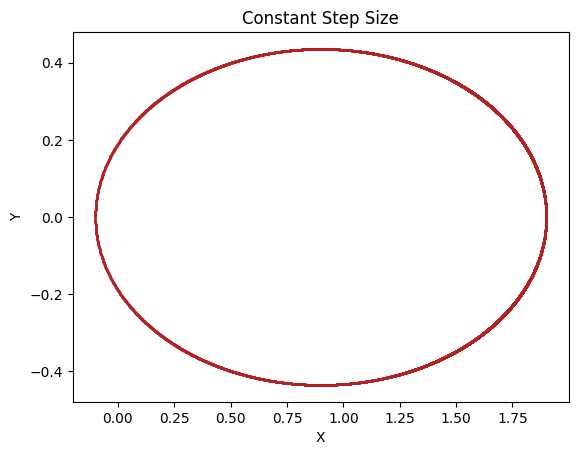

1922 integration points
Parameter Error: [ 0.0392107   0.120838   -0.14867181  0.00482042]
Minimum Velocity: 0.22941573387056163, Maximum Velocity: 4.358898857221701
Minimum Radius: 0.09999998746787171, Maximum Radius: 1.9
Eccentricity: 0.9000000062660641


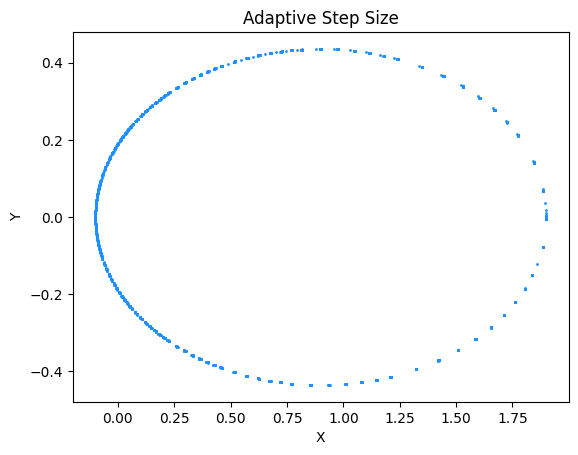

In [22]:
v_const = np.sqrt(x_array_const[:, 2]**2 + x_array_const[:, 3]**2)
r_const = np.sqrt(x_array_const[:, 0]**2 + x_array_const[:, 1]**2)
e_const = (max(r_const) - min(r_const))/2

print(f'{len(x_array_const,)} integration points')
print(f'Parameter Error: {x_array_const[0] - x_array_const[-1]}')
print(f"Minimum Velocity: {min(v_const)}, Maximum Velocity: {max(v_const)}")
print(f"Minimum Radius: {min(r_const)}, Maximum Radius: {max(r_const)}")
print(f"Eccentricity: {e_const}")

plt.figure(1)
plt.scatter(x_array_const[:, 0], x_array_const[:, 1], marker = 'o', s = 1, color = "firebrick")
plt.title("Constant Step Size")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

v_adapt = np.sqrt(x_array_adapt[:, 2]**2 + x_array_adapt[:, 3]**2)
r_adapt = np.sqrt(x_array_adapt[:, 0]**2 + x_array_adapt[:, 1]**2)
e_adapt = (max(r_adapt) - min(r_adapt))/2

print(f'{len(x_array_adapt,)} integration points')
print(f'Parameter Error: {x_array_adapt[0] - x_array_adapt[-1]}')
print(f"Minimum Velocity: {min(v_adapt)}, Maximum Velocity: {max(v_adapt)}")
print(f"Minimum Radius: {min(r_adapt)}, Maximum Radius: {max(r_adapt)}")
print(f"Eccentricity: {e_adapt}")

plt.figure(2)
plt.scatter(x_array_adapt[:, 0], x_array_adapt[:, 1], marker = 'o', s = 1, color = "dodgerblue")
plt.title("Adaptive Step Size")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# **Question 2** - Method of Lines

The method of lines is the way to do time-evolution of partial differention equations. Consider the thermal diffusion equation:
$$\frac{\partial T}{\partial t} = k\frac{\partial^2T}{\partial x^2}$$
where we set the thermal diffusivity $k$ to 1 for simplicity. We want to solve the following diffusion problem:
- A piece of metal is initially at $T = 1$, everywhere.
- At time $t = 0$, the end of the piece of metal at $x = 1$ is set to a temperature $T = 0$, and held at that temperature.
- The temperature at the other end of the rod $x = 0$ is held constant at $T = 1$.
- Calculate the temperature profile as a function of time T(x, t).

In the method of lines, we transform the PDE into an ODE by finite differencing the spatial derivative on a grid in $x$:
$$\frac{dT_i}{dt} = \frac{T_{i+1} - 2T_i + T_{i-1}}{(\Delta x)^2}$$
where $T_i$ is the temperature at $x = x_i$. If there are N grid points, there are N coupled ODEs that we can integrate in time. Using first principles, the LHS of that equation becomes:
$$\frac{T_{i+1} - T_{i}}{dt} = \frac{T_{i+1} - 2T_i + T_{i-1}}{(\Delta x)^2}$$
which can in turn be rearranged to solve for $T_{i+1}$ at position $x$ as:
$$T_{i+1} = \frac{\Delta t}{\Delta x^2}(T_{i+1} - 2T_i + T_{i-1}) + T_i$$

for some length element $\Delta x$ and time element $\Delta t$.

Use this method to solve the situation of the rod, and plot the temperature profile at different times.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def get_A(n, alpha, banded = True):
    # A is a banded matrix with the diagonal elements being 1 + 2*dx and the off-diagonal elements being -dx
    b = (1 + 2*alpha)*np.ones(n)
    a = -alpha*np.ones(n)
    c = -alpha*np.ones(n)

    # Boundary Conditions
    # The temperatures at the end are fixed so we need to adjust the matrix to endure that T[0] = T[n] = 0
    c[-1] = 0
    a[0] = 0

    # x = 0 is the left boundary so we need to adjust the matrix to ensure that T[0] = 0
    b[0] = 1.0
    a[1] = 0.0

    # x = 1 is the right boundary so we need to adjust the matrix to ensure that T[n] = 0
    b[-1] = 1.0
    c[-2] = 0.0

    if banded:
        diag_stack = np.vstack((a, b, c))
        return diag_stack
    else:
        # Create the tri-diagonal matrix
        # k = 0 specifies the main diagonal
        # k = 1 specifies the diagonal above the main diagonal
        # k = -1 specifies the diagonal below the main diagonal
        full_stack = np.diag(b, k = 0) + np.diag(a[1:], k = 1) + np.diag(c[:-1], k = -1)
        return full_stack

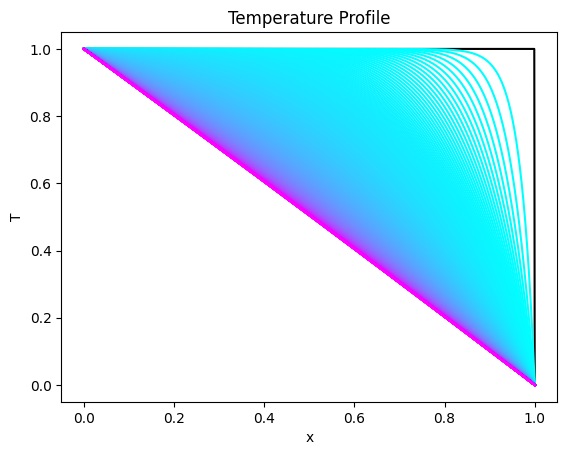

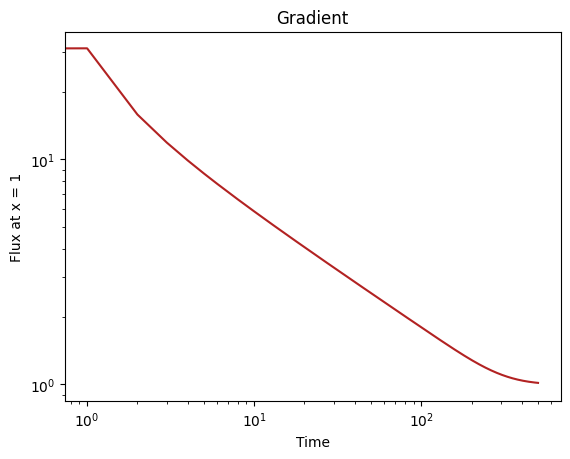

In [31]:
n = 1001
x = np.linspace(0, 1, n)
dx = x[1] - x[0]

# Initial temperature profile has T = 1 everywhere except at the right boundary
T = np.ones(n)
T[-1] = 0.0
dT = 1E-3
alpha = dT/dx**2
num_steps = 500

matrix_A = get_A(n, alpha, banded = True)

# Calculate and store the gradient at x = 1
grads = np.zeros(num_steps)
grads[0] = -(T[-1] - T[-2])

# Plot Initial Temperature Profile
plt.figure(1)

plt.plot(x, T, color = "black") # Plot the initial temperature profile

# Get Color Map
cmap = plt.get_cmap("cool")
colors = [cmap(i) for i in np.linspace(0, 1, num_steps)]

for i in range(1, num_steps):
    T = sp.linalg.solve_banded((1, 1), matrix_A, T)
    grads[i] = -(T[-1] - T[-2])/dx
    plt.plot(x, T, color = colors[i])

plt.title("Temperature Profile")
plt.xlabel("x")
plt.ylabel("T")
plt.show()

# Plot the gradient as a function of time
plt.figure(2)   
plt.plot(np.linspace(0, num_steps, num_steps), grads, color = "firebrick")
plt.title("Gradient")
plt.xlabel("Time")
plt.ylabel("Flux at x = 1")
plt.xscale("log")
plt.yscale("log")
plt.show()

Now doing the same thing but using the full matrix inverse instead of using the tridiagonal matrix solver. This will give the same result but is much slower as it has to calculate using the entire A matrix rather than just using the tri-diagonal entries.

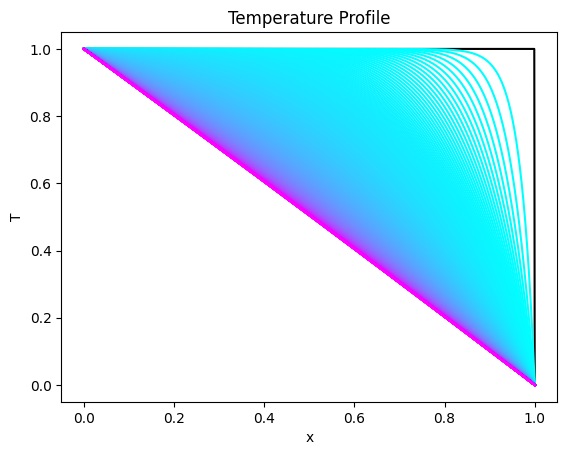

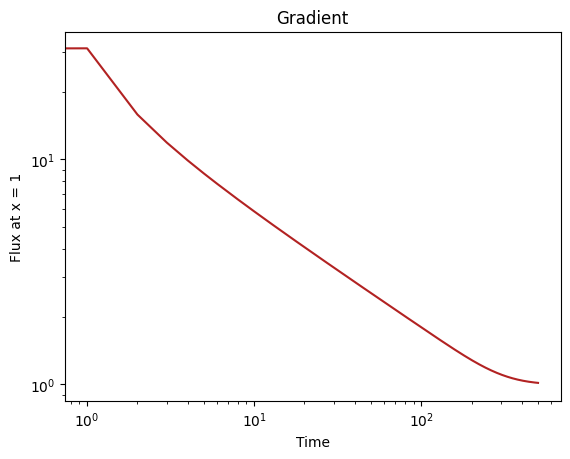

In [32]:
n = 1001
x = np.linspace(0, 1, n)
dx = x[1] - x[0]

# Initial temperature profile has T = 1 everywhere except at the right boundary
T = np.ones(n)
T[-1] = 0.0
dT = 1E-3
alpha = dT/dx**2
num_steps = 500

matrix_A = get_A(n, alpha, banded = False)

# Calculate and store the gradient at x = 1
grads = np.zeros(num_steps)
grads[0] = -(T[-1] - T[-2])

# Plot Initial Temperature Profile
plt.figure(1)

plt.plot(x, T, color = "black") # Plot the initial temperature profile

# Get Color Map
cmap = plt.get_cmap("cool")
colors = [cmap(i) for i in np.linspace(0, 1, num_steps)]

for i in range(1, num_steps):
    matrix_A_inv = np.linalg.inv(matrix_A)
    T = matrix_A_inv @ T
    grads[i] = -(T[-1] - T[-2])/dx
    plt.plot(x, T, color = colors[i])

plt.title("Temperature Profile")
plt.xlabel("x")
plt.ylabel("T")
plt.show()

# Plot the gradient as a function of time
plt.figure(2)   
plt.plot(np.linspace(0, num_steps, num_steps), grads, color = "firebrick")
plt.title("Gradient")
plt.xlabel("Time")
plt.ylabel("Flux at x = 1")
plt.xscale("log")
plt.yscale("log")
plt.show()